# GRPO: Group Relative Policy Optimization

**Goal**: Understand DeepSeek's GRPO — a simplified RL approach that eliminates the critic.

## The Problem GRPO Solves

| Method | Reward Model? | Critic (V network)? | RL? |
|--------|:---:|:---:|:---:|
| RLHF (PPO) | Yes | Yes | Yes |
| DPO | No | No | No |
| **GRPO** | Yes | **No** | Yes |

GRPO keeps the RL training loop (online generation) but **removes the critic network** by using group-based advantages.

## Key Idea

Instead of learning V(s) to estimate advantages:
1. For each prompt, generate a **group** of responses
2. Score all responses with a reward model
3. Compute **relative advantages** within the group (normalize rewards)
4. Use PPO-style clipped updates with these group advantages

Reference: DeepSeek-R1 (Shao et al., 2024)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import copy

torch.manual_seed(42)
np.random.seed(42)

---
## 1. GRPO vs PPO: The Core Difference

### PPO Advantage Estimation
```
For each step t in rollout:
    δ_t = r_t + γ V(s_{t+1}) - V(s_t)     ← needs V network!
    A_t = Σ (γλ)^l δ_{t+l}                 ← GAE
```

### GRPO Advantage Estimation
```
For each prompt x:
    Generate G responses: y_1, ..., y_G ~ π(·|x)
    Score each: r_1, ..., r_G = RM(x, y_i)
    Normalize: A_i = (r_i - mean(r)) / std(r)    ← no V network!
```

**GRPO uses the group itself as the baseline** instead of a learned value function.

This is a form of **REINFORCE with baseline**, where the baseline is the group mean.

---
## 2. Setup (Same Toy Problem)

In [2]:
N_CONTEXTS = 5
VOCAB_SIZE = 10
CONTEXT_DIM = 8

context_embeddings = torch.randn(N_CONTEXTS, CONTEXT_DIM)
true_preferences = torch.randn(N_CONTEXTS, VOCAB_SIZE)
true_preferences = torch.softmax(true_preferences * 2, dim=-1)

def get_true_reward(context_id, token_id):
    return true_preferences[context_id, token_id].item()


class ToyLM(nn.Module):
    def __init__(self, context_dim, vocab_size, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(context_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, vocab_size),
        )
    
    def forward(self, context):
        return self.net(context)
    
    def generate(self, context_id):
        context = context_embeddings[context_id].unsqueeze(0)
        dist = Categorical(logits=self.forward(context))
        return dist.sample().item()


class RewardModel(nn.Module):
    def __init__(self, context_dim, vocab_size, hidden_dim=32):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, hidden_dim)
        self.net = nn.Sequential(
            nn.Linear(context_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    
    def forward(self, context, token_ids):
        token_emb = self.token_embed(token_ids)
        combined = torch.cat([context, token_emb], dim=-1)
        return self.net(combined).squeeze(-1)


# Train SFT model
sft_model = ToyLM(CONTEXT_DIM, VOCAB_SIZE)
sft_opt = optim.Adam(sft_model.parameters(), lr=1e-2)
for epoch in range(100):
    for _ in range(20):
        ctx_ids = torch.randint(0, N_CONTEXTS, (32,))
        tokens = torch.stack([torch.multinomial(true_preferences[c], 1) for c in ctx_ids]).squeeze()
        loss = F.cross_entropy(sft_model(context_embeddings[ctx_ids]), tokens)
        sft_opt.zero_grad()
        loss.backward()
        sft_opt.step()

# Train reward model from comparisons
rm = RewardModel(CONTEXT_DIM, VOCAB_SIZE)
rm_opt = optim.Adam(rm.parameters(), lr=1e-3)
for epoch in range(200):
    ctx_ids = torch.randint(0, N_CONTEXTS, (64,))
    tok_a = torch.randint(0, VOCAB_SIZE, (64,))
    tok_b = torch.randint(0, VOCAB_SIZE, (64,))
    contexts = context_embeddings[ctx_ids]
    
    r_a_true = torch.tensor([get_true_reward(c.item(), t.item()) for c, t in zip(ctx_ids, tok_a)])
    r_b_true = torch.tensor([get_true_reward(c.item(), t.item()) for c, t in zip(ctx_ids, tok_b)])
    
    r_a = rm(contexts, tok_a)
    r_b = rm(contexts, tok_b)
    
    # Labels: 1 if a is preferred, simulate with Bradley-Terry
    prob_a = torch.exp(r_a_true) / (torch.exp(r_a_true) + torch.exp(r_b_true))
    labels = (torch.rand(64) < prob_a).float()
    
    loss = -labels * F.logsigmoid(r_a - r_b) - (1 - labels) * F.logsigmoid(r_b - r_a)
    loss = loss.mean()
    
    rm_opt.zero_grad()
    loss.backward()
    rm_opt.step()

print("SFT model and Reward model trained")

SFT model and Reward model trained


---
## 3. Implementing GRPO

In [3]:
def grpo_train(
    policy: ToyLM,
    ref_model: ToyLM,
    reward_model: RewardModel,
    n_iterations: int = 500,
    n_prompts: int = 8,
    group_size: int = 8,
    lr: float = 1e-3,
    kl_coef: float = 0.05,
    clip_eps: float = 0.2,
    n_epochs: int = 2,
) -> dict:
    """
    Train with GRPO (Group Relative Policy Optimization).
    
    Args:
        policy: Model to optimize
        ref_model: Frozen reference model
        reward_model: Reward model for scoring
        n_iterations: Number of outer iterations
        n_prompts: Number of prompts per iteration
        group_size: Number of responses per prompt (G)
        lr: Learning rate
        kl_coef: KL penalty coefficient
        clip_eps: PPO clipping parameter
        n_epochs: PPO epochs per iteration
    
    Returns:
        Training metrics
    """
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    history = {'rewards': [], 'kl': [], 'advantages': []}
    
    for iteration in range(n_iterations):
        # === Step 1: Sample prompts ===
        prompt_ids = torch.randint(0, N_CONTEXTS, (n_prompts,))
        
        # === Step 2: Generate GROUP of responses per prompt ===
        all_contexts = []
        all_tokens = []
        all_old_log_probs = []
        all_advantages = []
        
        with torch.no_grad():
            for prompt_id in prompt_ids:
                ctx = context_embeddings[prompt_id].unsqueeze(0).expand(group_size, -1)
                logits = policy(ctx)
                dist = Categorical(logits=logits)
                
                # Sample G responses
                tokens = dist.sample()  # [G]
                old_log_probs = dist.log_prob(tokens)  # [G]
                
                # Score with reward model
                rewards = reward_model(ctx, tokens)  # [G]
                
                # === GRPO's key innovation: group-relative advantages ===
                # Instead of V(s), use the group mean as baseline
                advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
                
                all_contexts.append(ctx)
                all_tokens.append(tokens)
                all_old_log_probs.append(old_log_probs)
                all_advantages.append(advantages)
        
        # Flatten
        contexts = torch.cat(all_contexts)       # [n_prompts * G, dim]
        tokens = torch.cat(all_tokens)            # [n_prompts * G]
        old_log_probs = torch.cat(all_old_log_probs)
        advantages = torch.cat(all_advantages)
        
        # === Step 3: PPO-style update with group advantages ===
        for epoch in range(n_epochs):
            # Current policy log probs
            new_logits = policy(contexts)
            new_dist = Categorical(logits=new_logits)
            new_log_probs = new_dist.log_prob(tokens)
            
            # Reference model for KL
            with torch.no_grad():
                ref_logits = ref_model(contexts)
                ref_dist = Categorical(logits=ref_logits)
            
            # PPO ratio
            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            
            # Clipped objective
            surr1 = ratio * advantages.detach()
            surr2 = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * advantages.detach()
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # KL penalty (per-token KL divergence from reference)
            kl = torch.distributions.kl_divergence(new_dist, ref_dist).mean()
            
            loss = policy_loss + kl_coef * kl
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Track metrics
        with torch.no_grad():
            avg_reward = reward_model(
                contexts[:group_size], tokens[:group_size]
            ).mean().item()
        
        history['rewards'].append(avg_reward)
        history['kl'].append(kl.item())
        history['advantages'].append(advantages.abs().mean().item())
        
        if (iteration + 1) % 100 == 0:
            print(f"Iter {iteration+1}: reward={avg_reward:.4f}, KL={kl.item():.4f}")
    
    return history

In [4]:
# Train GRPO
grpo_policy = copy.deepcopy(sft_model)
ref_model = copy.deepcopy(sft_model)
for p in ref_model.parameters():
    p.requires_grad = False

print("Training GRPO...\n")
grpo_metrics = grpo_train(
    policy=grpo_policy,
    ref_model=ref_model,
    reward_model=rm,
    n_iterations=500,
    n_prompts=8,
    group_size=8,
    kl_coef=0.05,
)

Training GRPO...

Iter 100: reward=0.5318, KL=0.2810
Iter 200: reward=0.2667, KL=0.3944
Iter 300: reward=0.2667, KL=0.3998
Iter 400: reward=0.2667, KL=0.4282
Iter 500: reward=0.4027, KL=0.2726


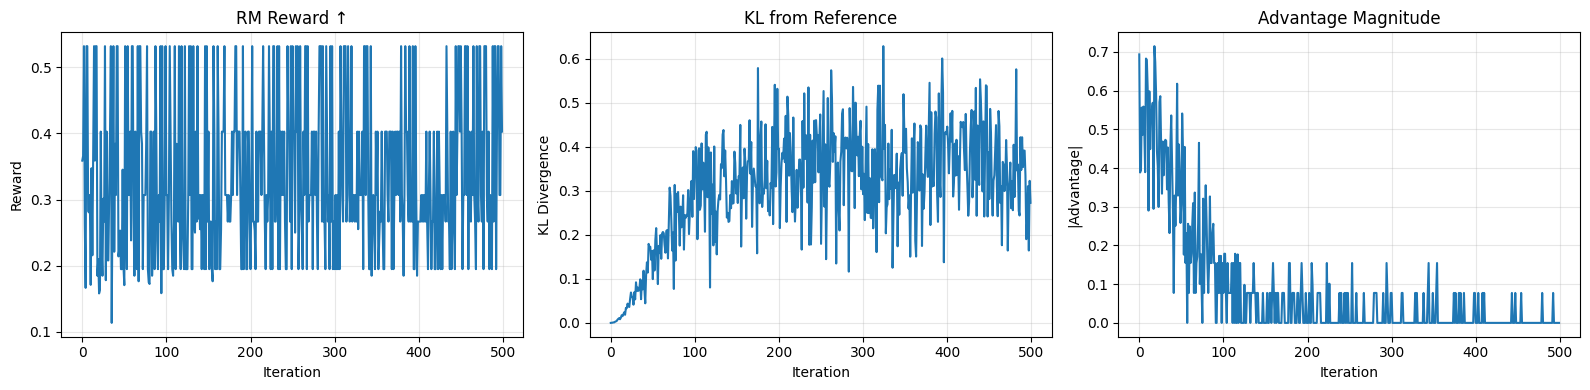

In [5]:
# Plot GRPO training
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

ax = axes[0]
ax.plot(grpo_metrics['rewards'])
ax.set_xlabel('Iteration')
ax.set_ylabel('Reward')
ax.set_title('RM Reward ↑')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(grpo_metrics['kl'])
ax.set_xlabel('Iteration')
ax.set_ylabel('KL Divergence')
ax.set_title('KL from Reference')
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.plot(grpo_metrics['advantages'])
ax.set_xlabel('Iteration')
ax.set_ylabel('|Advantage|')
ax.set_title('Advantage Magnitude')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Compare all methods
print("Final comparison (true reward):\n")
print(f"{'Context':>8}  {'SFT':>8}  {'GRPO':>8}")
print("-" * 28)

sft_total, grpo_total = 0, 0
for ctx in range(N_CONTEXTS):
    sft_r = np.mean([get_true_reward(ctx, sft_model.generate(ctx)) for _ in range(200)])
    grpo_r = np.mean([get_true_reward(ctx, grpo_policy.generate(ctx)) for _ in range(200)])
    print(f"{ctx:>8}  {sft_r:>8.4f}  {grpo_r:>8.4f}  {'✓' if grpo_r > sft_r else '✗'}")
    sft_total += sft_r
    grpo_total += grpo_r

print(f"\n{'Overall':>8}  {sft_total/N_CONTEXTS:>8.4f}  {grpo_total/N_CONTEXTS:>8.4f}")

Final comparison (true reward):

 Context       SFT      GRPO
----------------------------
       0    0.4351    0.5919  ✓
       1    0.2737    0.4789  ✓
       2    0.7752    0.8504  ✓
       3    0.3727    0.5796  ✓
       4    0.9876    0.9925  ✓

 Overall    0.5688    0.6987


---
## 4. Group Size Ablation

The group size G is GRPO's key hyperparameter:
- **Small G**: Noisy advantage estimates (like REINFORCE)
- **Large G**: Better estimates but more compute per iteration

In [7]:
group_results = {}
for G in [2, 4, 8, 16]:
    print(f"\nGroup size G={G}...")
    policy = copy.deepcopy(sft_model)
    metrics = grpo_train(
        policy=policy, ref_model=ref_model, reward_model=rm,
        n_iterations=300, n_prompts=8, group_size=G,
    )
    group_results[f"G={G}"] = metrics


Group size G=2...
Iter 100: reward=0.1948, KL=0.2028
Iter 200: reward=0.3068, KL=0.0337
Iter 300: reward=0.2667, KL=0.3923

Group size G=4...
Iter 100: reward=0.2667, KL=0.1270
Iter 200: reward=0.5318, KL=0.4649
Iter 300: reward=0.1948, KL=0.4632

Group size G=8...
Iter 100: reward=0.4027, KL=0.2777
Iter 200: reward=0.1948, KL=0.4358
Iter 300: reward=0.5318, KL=0.2270

Group size G=16...
Iter 100: reward=0.3068, KL=0.2328
Iter 200: reward=0.2667, KL=0.4119
Iter 300: reward=0.5318, KL=0.3090


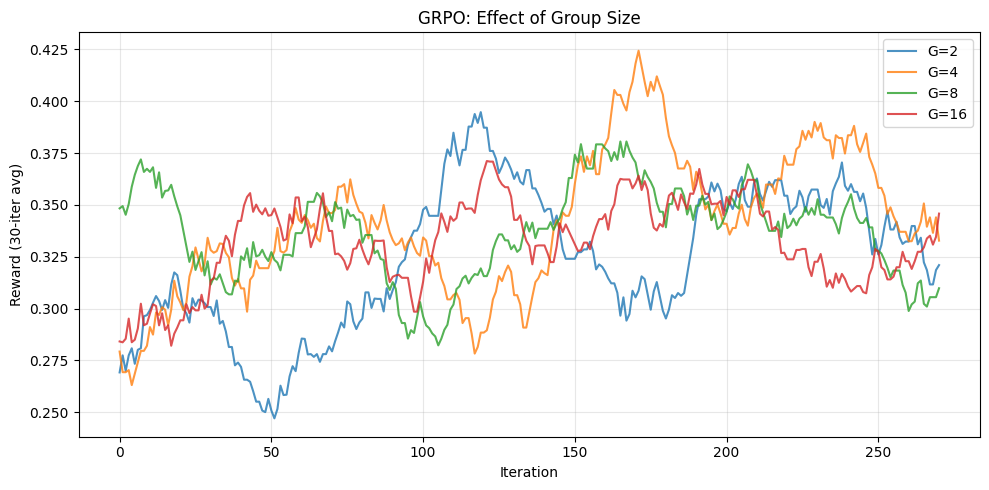

Larger groups → better baseline → lower variance → faster learning
But: more generations per step → more compute


In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
window = 30
for label, data in group_results.items():
    smoothed = np.convolve(data['rewards'], np.ones(window)/window, mode='valid')
    ax.plot(smoothed, label=label, alpha=0.8)
ax.set_xlabel('Iteration')
ax.set_ylabel(f'Reward ({window}-iter avg)')
ax.set_title('GRPO: Effect of Group Size')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Larger groups → better baseline → lower variance → faster learning")
print("But: more generations per step → more compute")

---
## 5. GRPO + Verifiable Rewards (RLVR)

GRPO is especially powerful with **verifiable rewards** — tasks where correctness can be checked automatically.

### Examples
- **Math**: Check if the final answer is correct
- **Code**: Run tests to verify correctness
- **Logic**: Verify logical deductions

### Why GRPO + RLVR Works Well

1. **Binary reward** (correct/incorrect) is easy to compute — no reward model needed!
2. **Group sampling** naturally explores: some attempts correct, some not
3. **Relative advantage**: "this solution is better than average in this group"

This is how **DeepSeek-R1** was trained:
```
For each math problem:
    Generate G reasoning traces with chain-of-thought
    Check which ones get the right answer (reward = 1 or 0)
    GRPO update: reinforce correct traces, suppress incorrect ones
```

In [9]:
# Simulate RLVR: binary reward based on "correctness"
# For each context, there's exactly one correct token
correct_tokens = torch.argmax(true_preferences, dim=1)  # Best token per context

def verifiable_reward(context_id: int, token_id: int) -> float:
    """Binary reward: 1 if correct, 0 otherwise."""
    return 1.0 if token_id == correct_tokens[context_id].item() else 0.0

print("Correct tokens per context:")
for ctx in range(N_CONTEXTS):
    print(f"  Context {ctx}: token {correct_tokens[ctx].item()}")

Correct tokens per context:
  Context 0: token 2
  Context 1: token 2
  Context 2: token 4
  Context 3: token 1
  Context 4: token 6


In [10]:
def grpo_rlvr_train(
    policy: ToyLM,
    ref_model: ToyLM,
    n_iterations: int = 500,
    n_prompts: int = 8,
    group_size: int = 16,
    lr: float = 1e-3,
    kl_coef: float = 0.05,
    clip_eps: float = 0.2,
) -> dict:
    """
    GRPO with verifiable (binary) rewards — no reward model needed.
    
    Args:
        policy: Model to optimize
        ref_model: Frozen reference model
        n_iterations: Training iterations
        n_prompts: Prompts per iteration
        group_size: Responses per prompt
        lr: Learning rate
        kl_coef: KL penalty
        clip_eps: PPO clipping
    
    Returns:
        Training metrics
    """
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    history = {'accuracy': [], 'rewards': []}
    
    for iteration in range(n_iterations):
        prompt_ids = torch.randint(0, N_CONTEXTS, (n_prompts,))
        
        all_contexts, all_tokens, all_old_log_probs, all_advantages = [], [], [], []
        total_correct = 0
        total_samples = 0
        
        with torch.no_grad():
            for prompt_id in prompt_ids:
                ctx = context_embeddings[prompt_id].unsqueeze(0).expand(group_size, -1)
                logits = policy(ctx)
                dist = Categorical(logits=logits)
                tokens = dist.sample()
                old_log_probs = dist.log_prob(tokens)
                
                # Binary verifiable rewards
                rewards = torch.tensor([
                    verifiable_reward(prompt_id.item(), t.item()) for t in tokens
                ])
                
                total_correct += rewards.sum().item()
                total_samples += group_size
                
                # Group-relative advantages
                if rewards.std() > 0:
                    advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
                else:
                    advantages = rewards - rewards.mean()
                
                all_contexts.append(ctx)
                all_tokens.append(tokens)
                all_old_log_probs.append(old_log_probs)
                all_advantages.append(advantages)
        
        contexts = torch.cat(all_contexts)
        tokens = torch.cat(all_tokens)
        old_log_probs = torch.cat(all_old_log_probs)
        advantages = torch.cat(all_advantages)
        
        # PPO update
        new_logits = policy(contexts)
        new_dist = Categorical(logits=new_logits)
        new_log_probs = new_dist.log_prob(tokens)
        
        with torch.no_grad():
            ref_dist = Categorical(logits=ref_model(contexts))
        
        ratio = torch.exp(new_log_probs - old_log_probs.detach())
        surr1 = ratio * advantages.detach()
        surr2 = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * advantages.detach()
        policy_loss = -torch.min(surr1, surr2).mean()
        kl = torch.distributions.kl_divergence(new_dist, ref_dist).mean()
        
        loss = policy_loss + kl_coef * kl
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        accuracy = total_correct / total_samples
        history['accuracy'].append(accuracy)
        history['rewards'].append(total_correct / n_prompts)
        
        if (iteration + 1) % 100 == 0:
            print(f"Iter {iteration+1}: accuracy={accuracy:.1%}")
    
    return history

In [11]:
# Train GRPO with verifiable rewards
rlvr_policy = copy.deepcopy(sft_model)

print("Training GRPO + RLVR...\n")
rlvr_metrics = grpo_rlvr_train(
    policy=rlvr_policy,
    ref_model=ref_model,
    n_iterations=500,
    group_size=16,
)

Training GRPO + RLVR...

Iter 100: accuracy=92.2%
Iter 200: accuracy=98.4%
Iter 300: accuracy=98.4%
Iter 400: accuracy=100.0%
Iter 500: accuracy=99.2%


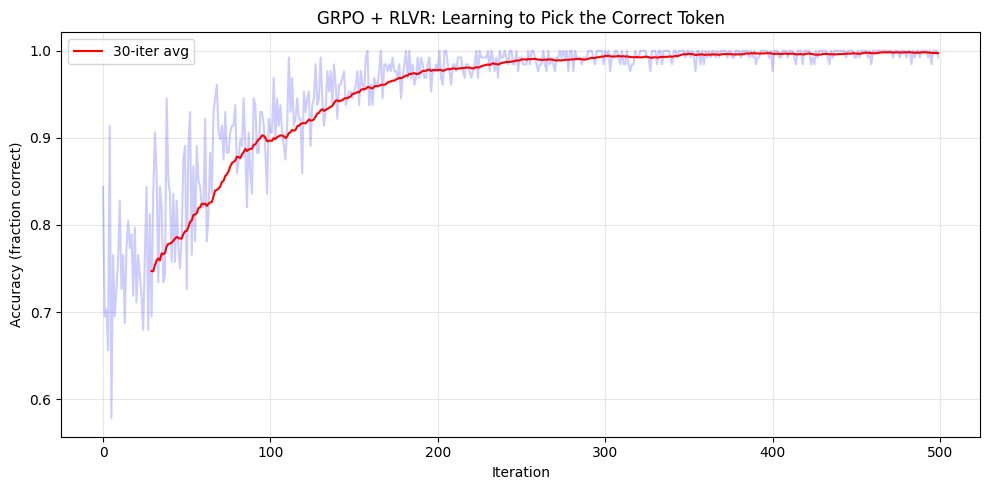

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
window = 30
smoothed = np.convolve(rlvr_metrics['accuracy'], np.ones(window)/window, mode='valid')
ax.plot(rlvr_metrics['accuracy'], alpha=0.2, color='blue')
ax.plot(range(window-1, len(rlvr_metrics['accuracy'])), smoothed, color='red', label=f'{window}-iter avg')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy (fraction correct)')
ax.set_title('GRPO + RLVR: Learning to Pick the Correct Token')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 6. The Full Landscape: Comparing All Methods

| Method | Reward Source | Advantage | Online? | Complexity |
|--------|-------------|-----------|---------|------------|
| **RLHF (PPO)** | Reward model | GAE + critic V(s) | Yes | High |
| **DPO** | Implicit (log ratio) | N/A (supervised) | No | Low |
| **GRPO** | RM or verifiable | Group-relative | Yes | Medium |
| **GRPO + RLVR** | Verifiable (exact) | Group-relative | Yes | Medium |

### When to Use What

| Scenario | Best Method |
|----------|-------------|
| Have preference pairs, want simplicity | **DPO** |
| Need online exploration, have reward model | **GRPO** |
| Math/code tasks with verifiable answers | **GRPO + RLVR** |
| Maximum flexibility, complex reward shaping | **RLHF (PPO)** |
| Limited compute, offline data only | **DPO** |

---

## Key Takeaways

1. **GRPO eliminates the critic** by using group-relative advantages

2. **Group baseline**: mean reward in the group replaces V(s) — simpler and effective

3. **Group size matters**: larger groups → lower variance → better learning

4. **RLVR** combines GRPO with verifiable rewards — no reward model needed at all

5. **This is how DeepSeek-R1 was trained**: GRPO + math verification = emergent reasoning

---

## Congratulations!

You've now covered the full journey:

```
MDPs → Q-Learning → DQN → REINFORCE → PPO → RLHF → DPO → GRPO
```

From tabular RL to the algorithms powering modern LLM alignment.